In [2]:
import numpy as np
import matplotlib.pyplot as pl
import pandas as pd
from astropy.table import Table
import sys
sys.path.append("../")
import read_mist_models
from matplotlib import colors
from scipy.interpolate import interp1d
pl.rc('text', usetex=True)

%matplotlib inline

In [16]:
# fix format of data and load it into a pandas dataframe
mask = [False, False, True, True, False, False, False, True, True]
header = ["epic_number", "mix_mean", "mix_sd", "mix_neff", "mix_rhat", "logdeltaQ_mean", "logdeltaQ_sd", "logdeltaQ_neff", "logdeltaQ_rhat",
         "logQ0_mean", "logQ0_sd", "logQ0_neff", "logQ0_rhat", "logperiod_mean", "logperiod_sd", "logperiod_neff", "logperiod_rhat",
         "logamp_mean", "logamp_sd", "logamp_neff", "logamp_rhat", "logs2_mean", "logs2_sd", "logs2_neff", "logs2_rhat", "acfpeak"]
with open("../output/out.dat", "r") as file:
    lines = file.readlines()
    nstars = (np.int((len(lines)/7)))
    data = np.zeros((nstars, 26))
    for i in range(nstars):
        data[i, 0] = lines[7*i].split()[0]
        for j in range(6):
            data[i, 4*j+1:4*(j+1)+1] = np.array(lines[7*i+j].split())[mask]
        acfpeak = lines[7*i+6].split()[2]
        if "None" in acfpeak:
            data[i, 25] = np.nan
        else:
            data[i, 25] = acfpeak
            
data = pd.DataFrame(data=data, columns=header)
# read in isochrone
iso = read_mist_models.ISOCMD('../MIST_iso_5da0dbfba0a60.iso.cmd')
# load in Kepler-Gaia crossmatch and make some cuts 
k2dr2 = Table.read('../k2_dr2_1arcsec.fits', format='fits')
k2dr2 = k2dr2.to_pandas()
df = pd.merge(k2dr2, data, left_on='epic_number', right_on='epic_number')

Reading in: ../MIST_iso_5da0dbfba0a60.iso.cmd


/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2963: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2963: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2963: TableReplaceWarning: converted column 'k2_kepmagerr' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [22]:
good_parallax = df["parallax_error"] < 0.1
unimodal = (df["r_modality_flag"] == 1) & (df["r_result_flag"] == 1)
has_color = np.isfinite(df["bp_rp"])
good_bp = df["phot_bp_mean_flux_error"]/df[u'phot_bp_mean_flux'] < 0.01
good_rp = df[u'phot_rp_mean_flux_error']/df[u'phot_rp_mean_flux'] < 0.01
good_mg = df[u'phot_g_mean_flux_error']/df[u'phot_g_mean_flux'] < 0.01
in_r_range = df["r_est"] < 500
mask = good_parallax & unimodal & has_color & good_bp & good_rp & good_mg & in_r_range

In [25]:
age_ind = iso.age_index(9.0) #returns the index for the desired age
iso_bp_rp = iso.isocmds[age_ind]['Gaia_BP_MAWb'] - iso.isocmds[age_ind]['Gaia_RP_MAW']
iso_mg = iso.isocmds[age_ind]['Gaia_G_MAW']
mass_mask = (iso.isocmds[age_ind]['initial_mass'] < 2.0) & (iso.isocmds[age_ind]['initial_mass'] > 0.2)
iso_bp_rp = iso_bp_rp[mass_mask]
iso_mg = iso_mg[mass_mask]

in_color_range = (df["bp_rp"] > min(iso_bp_rp)) & (df["bp_rp"] < max(iso_bp_rp))
mask = mask & in_color_range

interpolator = interp1d(iso_bp_rp, iso_mg)
iso_mg_interp = interpolator(df[mask]['bp_rp'])

/usr/local/lib/python3.7/site-packages/matplotlib/colors.py:1211: RuntimeWarning: invalid value encountered in less
  res_mask = result.data < 0


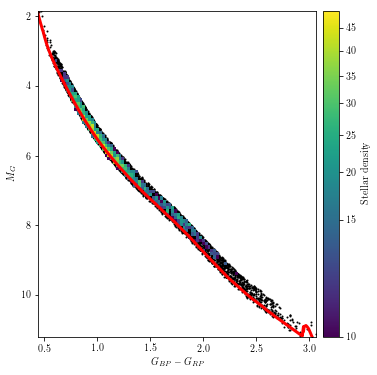

6139


In [26]:
correction = 5*np.log10(df[mask]["r_est"])-5
bp_rp, mg = np.array(df[mask]["bp_rp"]), np.array(df[mask]["phot_g_mean_mag"])-correction
is_ms = (mg - iso_mg_interp < 0.1) & (iso_mg_interp - mg < 0.4)

fig, ax = pl.subplots(figsize=(6, 6))

# only show 2D-histogram for bins with more than 10 stars in them
h = ax.hist2d(bp_rp[is_ms], mg[is_ms], bins=100, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)

# fill the rest with scatter (set rasterized=True if saving as vector graphics)
ax.scatter(bp_rp[is_ms], mg[is_ms], alpha=1, s=1, color='k', zorder=0)
ax.plot(iso_bp_rp, iso_mg, 'r', linewidth=3) 
ax.invert_yaxis()
cb = fig.colorbar(h[3], ax=ax, pad=0.02)
ax.set_xlabel(r'$G_{BP} - G_{RP}$')
ax.set_ylabel(r'$M_G$')
cb.set_label(r"$\mathrm{Stellar~density}$")
pl.show()
print(sum(is_ms))

1909


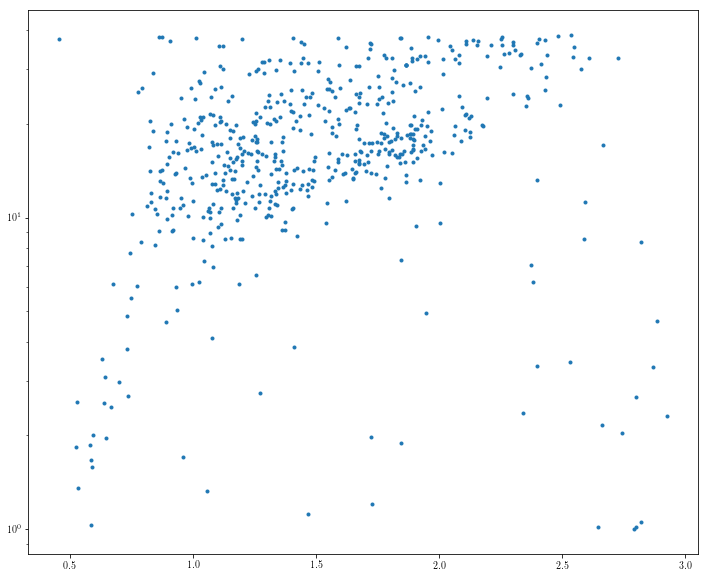

In [27]:
#good_period = np.abs(np.exp(df['logperiod_mean']) - df['acfpeak']) < 1
good_period = (df['logperiod_neff'] > 5000) & (np.abs(np.exp(df['logperiod_mean']) - df['acfpeak']) < 1)
print(sum(good_period))
period = np.exp(df[mask & is_ms & good_period]['logperiod_mean'])
color = df[mask & is_ms & good_period]['bp_rp']
fig = pl.figure(figsize=(12, 10))
pl.semilogy(color, period, '.', alpha=1)
#pl.ylim([10, 50])

18806


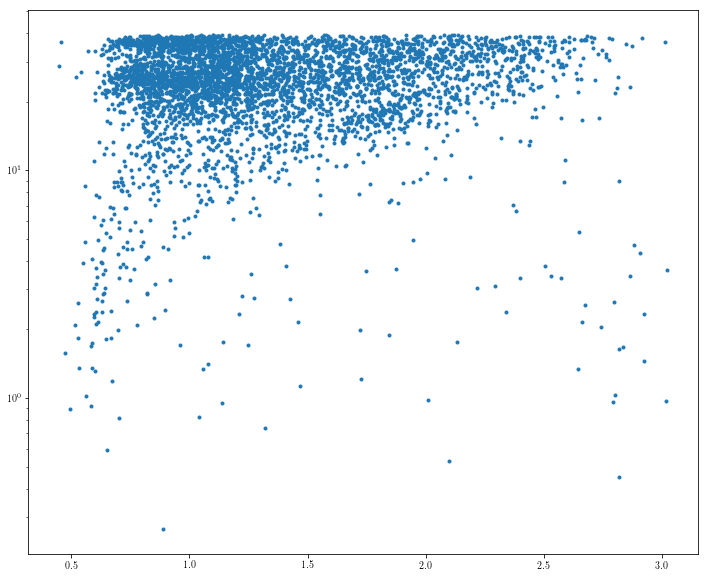

In [30]:
good_period = np.abs(np.exp(df['logperiod_mean']) - df['acfpeak']) < 10
print(sum(good_period))
period = (df[mask & is_ms & good_period]['acfpeak'])
color = df[mask & is_ms & good_period]['bp_rp']
fig = pl.figure(figsize=(12, 10))
pl.semilogy(color, period, '.', alpha=1)